# Improvement in classification, based on feature selection
Using the information about the top
correlating features obtained in item (4), transform the full data set **`train_smpl`** so as to keep the
following attributes:
* Using only the top 5 pixels from each **`train_smpl_\<label>`**.
* Using only the top 10 pixels from each **`train_smpl_\<label>`**.
* Using only the top 20 pixels from each **`train_smpl_\<label>`**.
* You will have three data sets, with approximately 50, 100 and 200 features (pixels) each.
Repeat the experiment described in item (3) on these three data sets.

In [1]:
import numpy as np
from IPython.utils import io

In [2]:
from Scripts import pixelFinder as pf 
from Scripts.NaiveBayse import NaiveBayseGaussian as nbg
from Scripts import helperfn as hf
from Scripts import plotScripts as ps
%load_ext autoreload
%autoreload 2


In [42]:
def get_top_pixels(n):
    pixel_order = []
    for i in range(-1, 10):
        pixel_order.append(np.array(pf.bestPixels(i, n)))
    return pixel_order

def grab_n_pixels(pixel_order, n):
    output = []

    # j is the pixel order list
    for j in range(len(pixel_order)):
        output.append(pixel_order[j][:n]) 

    return output


def data_lists():
    data = []
    for i in range(-1, 10):
        data.append(helperfn.get_data(i))
    return data

# This range could be incorrect might need to be (0,12)
def build_classifiers(data, y_labels, pixel_order, result_label_set=(0,11), balance_classes=False):
    classifiers = []
    scores = []
    dataset = []
    for i in range(result_label_set[0], result_label_set[1]):
        X = np.take(data, pixel_order[i], axis=1)
        y = y_labels[i]
        classifier, score, local_data = nbg.nbg_model_custom_data(X, y, data_label=i-1, balance_classes=balance_classes)
        classifiers += [classifier]
        scores += [score]
        dataset += [local_data]

    return classifiers, scores, dataset


def get_labels():
    labels = []
    for i in range(-1, 10):
        labels.append(hf.get_results(i))
    
    return labels

def run_classifier(x_data, y, pixel_order, n_pixels=5, verbose=False, **kwargs):
    scores_list = []
    classifiers_list = []
    data_list = []

    #pixels = grab_n_pixels(pixel_order, 0)

    # No 0 pixels so start at 1 
    for i in range(1, n_pixels + 1):
        hf.update_progress(i/(n_pixels+1), message='running all classifiers, could be slow')
        pixels = grab_n_pixels(pixel_order, i)
        #print(len(pixels))
        if not verbose:
            print('Classifying pixel: ' , i)
            with io.capture_output() as captured:
                classifier, scores, data = build_classifiers(x_data, y, pixels,  balance_classes=True, **kwargs)
        else:
            classifier,  scores, data = build_classifiers(x_data, y, pixels, balance_classes=True, **kwargs)
        
        scores_list.append(scores)
        data_list.append(data)
        classifiers_list.append(classifier)
    
    return scores_list, data_list, classifiers_list


def unzip_all_scores(scores_list):

    train_scores = []
    test_scores = []

    # loops over pixels
    for i in range(len(scores_list)):
        train, test = ps.unzip_scores(scores_list[i])
        train_scores.append(train)
        test_scores.append(test)
    
    return train_scores, test_scores


def using_n_pixelrun_classifier(x_data, y, pixel_order,best_pixel_indicies, n_pixels=5, verbose=False, **kwargs):
    scores_list = []
    classifiers_list = []
    data_list = []

    #pixels = grab_n_pixels(pixel_order, 0)

    # No 0 pixels so start at 1 
    for i in range(0, 11):
        hf.update_progress(i/10, message='building all classifiers with best pixel amount for each')
        pixels = grab_n_pixels(pixel_order, best_pixel_indicies[i])

        if not verbose:
            print('Classifying pixel: ' , i)
            with io.capture_output() as captured:
                classifier, scores, data = build_classifiers(x_data, y, pixels,result_label_set=(i,i+1), balance_classes=True, **kwargs)
        else:
            classifier,  scores, data = build_classifiers(x_data, y, pixels, result_label_set=(i,i+1), balance_classes=True, **kwargs)
        
        scores_list.append(scores)
        data_list.append(data)
        classifiers_list.append(classifier)
    
    return classifiers_list, scores_list, data_list, 





In [4]:
pixel_order = get_top_pixels(2304)

In [5]:
labels = get_labels()
x_data = hf.get_data_noresults()

In [24]:
#pixel_order = get_top_pixels(10)



scores_list, data_list, classifiers_list = run_classifier(x_data, labels, pixel_order,result_label_set=(0,11), n_pixels = 150)

train_scores , test_scores = unzip_all_scores(scores_list)







running all classifiers, could be slow
Progress: [####################] 99.3%
Classifying pixel:  150


### Print line chart

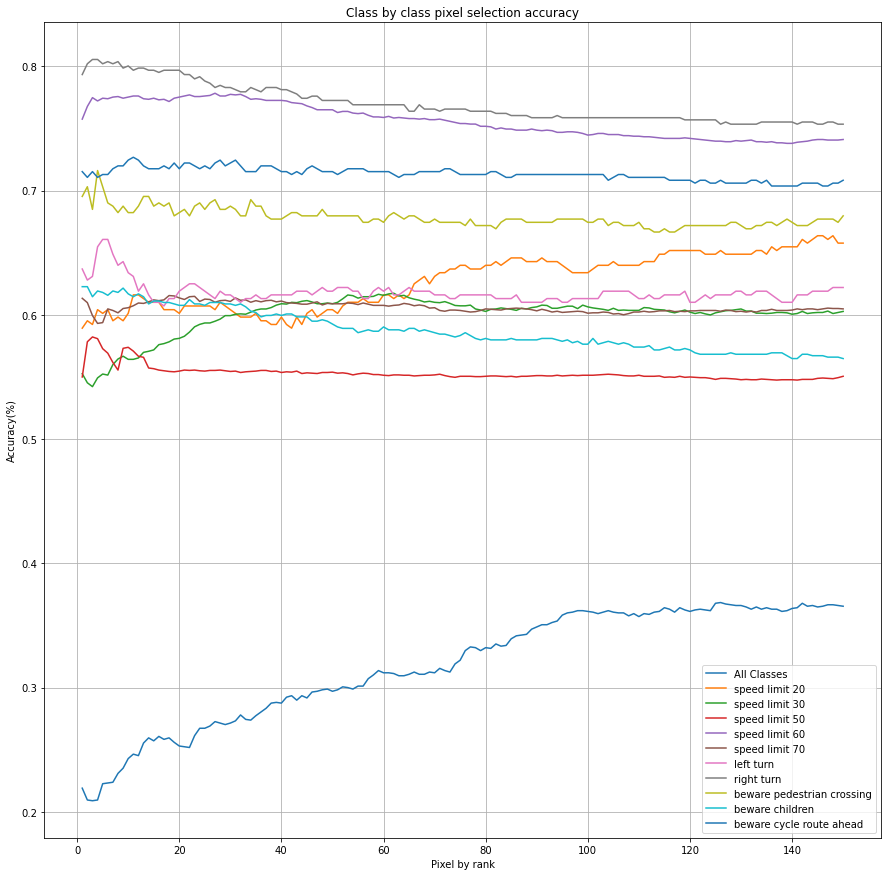

In [27]:
ps.plot_line_graph(np.array(train_scores))

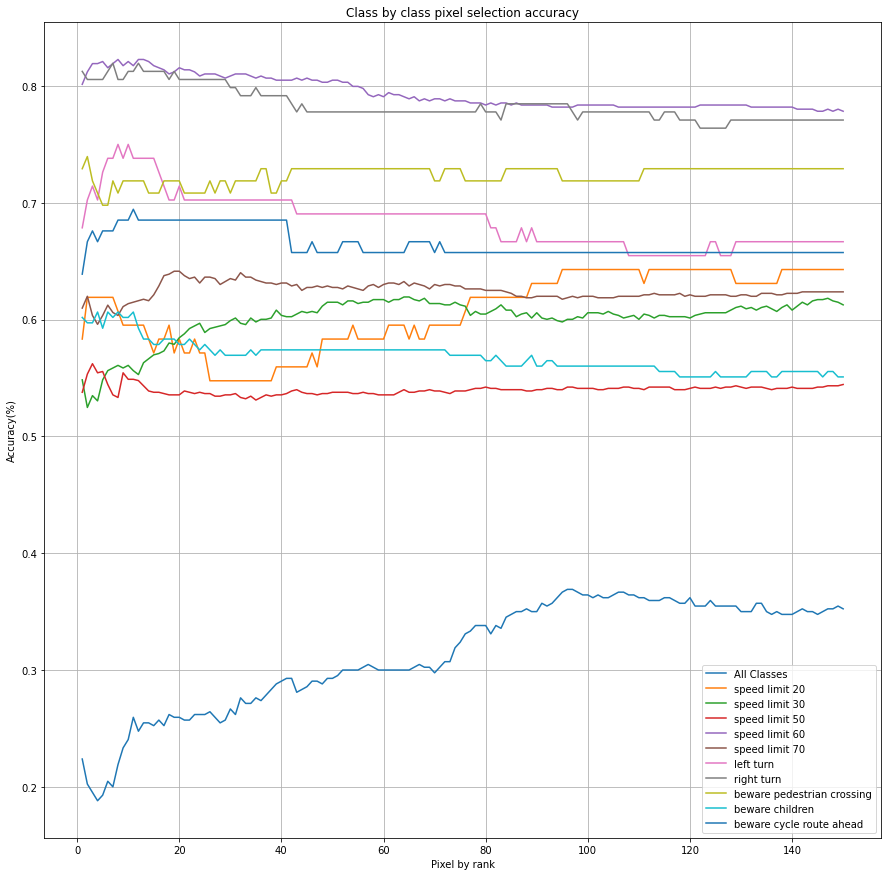

In [26]:
ps.plot_line_graph(np.array(test_scores))

In [29]:
best_pixel_depth = pf.get_best_n_pixels_all_classes(np.array(test_scores))
print(best_pixel_depth)

[95, 94, 63, 2, 7, 18, 7, 6, 1, 3, 10]


In [72]:

classifiers_5_pixels, scores_5_pixels, dataset_5_pixels = build_classifiers(x_data, labels, grab_n_pixels(pixel_order, 5))
classifiers_10_pixels, scores_10_pixels, dataset_10_pixels = build_classifiers(x_data, labels, grab_n_pixels(pixel_order, 10))
classifiers_20_pixels, scores_20_pixels, dataset_20_pixels = build_classifiers(x_data, labels, grab_n_pixels(pixel_order, 20))
classifiers_our_pixels, scores_our_pixels, dataset_our_pixels = using_n_pixelrun_classifier(x_data, labels, grab_n_pixels(pixel_order, 149), best_pixel_depth)




building all classifiers with best pixel amount for each
Progress: [####################] 100.0%
Classifying pixel:  10


In [73]:
np.array(scores_our_pixels)


array([[[0.35833333, 0.36666667]],

       [[0.64285714, 0.63095238]],

       [[0.6151464 , 0.61711712]],

       [[0.57833333, 0.55333333]],

       [[0.77526596, 0.81914894]],

       [[0.6155303 , 0.63888889]],

       [[0.64880952, 0.73809524]],

       [[0.80381944, 0.8125    ]],

       [[0.6953125 , 0.72916667]],

       [[0.61458333, 0.59722222]],

       [[0.72453704, 0.68518519]]])

In [75]:
new_list = []

for i in range(0,11):
    print(scores_our_pixels[i][0])
    new_list.append(scores_our_pixels[i][0])

(0.35833333333333334, 0.36666666666666664)
(0.6428571428571429, 0.6309523809523809)
(0.6151463963963963, 0.6171171171171171)
(0.5783333333333334, 0.5533333333333333)
(0.7752659574468085, 0.8191489361702128)
(0.615530303030303, 0.6388888888888888)
(0.6488095238095238, 0.7380952380952381)
(0.8038194444444444, 0.8125)
(0.6953125, 0.7291666666666666)
(0.6145833333333334, 0.5972222222222222)
(0.7245370370370371, 0.6851851851851852)


In [80]:
train_score_5_pixels , test_score_5_pixels = ps.convert_percentage(ps.unzip_scores(scores_5_pixels))
train_score_10_pixels , test_score_10_pixels = ps.convert_percentage(ps.unzip_scores(scores_10_pixels))
train_score_20_pixels , test_score_20_pixels = ps.convert_percentage(ps.unzip_scores(scores_20_pixels))
train_score_our_pixels , test_score_our_pixels = ps.convert_percentage(ps.unzip_scores(new_list))



train_score_5_pixels = train_score_5_pixels.astype(int)
test_score_5_pixels = test_score_5_pixels.astype(int)
train_score_10_pixels = train_score_10_pixels.astype(int)
test_score_10_pixels = test_score_10_pixels.astype(int)
train_score_20_pixels = train_score_20_pixels.astype(int)
test_score_20_pixels = test_score_20_pixels.astype(int)
train_score_our_pixels = train_score_our_pixels.astype(int)
test_score_our_pixels = test_score_our_pixels.astype(int)






In [88]:
# print(new_train_score_5_pixels)
# print(new_train_scores_10_pixels)
# print(new_train_score_20_pixels)
# print(new_train_score_our_pixels)

# print(len(new_train_score_5_pixels))
# print(len(new_train_scores_10_pixels))
# print(len(new_train_score_20_pixels))
# print(len(new_train_score_our_pixels))



data_to_print = [test_score_5_pixels.astype(int), test_score_10_pixels.astype(int), test_score_20_pixels.astype(int), test_score_our_pixels.astype(int)]

print(np.array(data_to_print))



[[25 97 78 73 72 70 73 73 69 62 65]
 [23 66 60 49 71 59 58 71 61 51 59]
 [21 52 55 41 70 54 53 69 55 46 55]
 [36 63 61 55 81 63 73 81 72 59 68]]


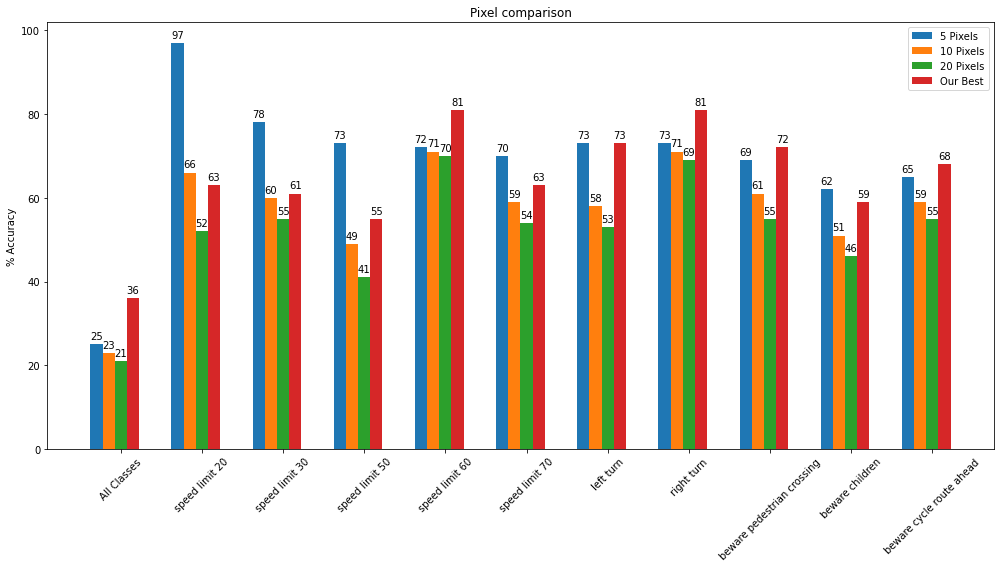

In [89]:
ps.plot_scores(data_to_print, ['5 Pixels','10 Pixels','20 Pixels','Our Best'], title='Pixel comparison')
